Import all the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud, STOPWORDS

import re
import string
import contractions
import textstat
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from nltk import WordNetLemmatizer
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

In [2]:
df = pd.read_csv("../data/preprocessed/master_fakenews.csv")

Let's now fix any contractions in the text and remove extra whitespace

In [3]:
def normalize_text(text):
    text = contractions.fix(str(text))
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [4]:
df["prep_text"] = df["clean_text"].apply(normalize_text)

In [5]:
wnl = WordNetLemmatizer()
stop = set(stopwords.words("english"))

To ensure that non-letter characters are still in the text, as well convert any leftover uppercase to lowercase, remove stopwords, and lemmatize

In [6]:
def clean_text(text):
    text = re.sub("[^a-zA-Z]", " ", str(text))
    text = text.lower().split()
    text = [wnl.lemmatize(word) for word in text if word not in stop]
    return " ".join(text)

In [7]:
df["prep_text"] = df["clean_text"].apply(clean_text)

In [12]:
df["word_count"] = df["prep_text"].str.split().str.len()

In [13]:
df["unique_words"] = df["prep_text"].apply(
    lambda x: len(set(str(x).split()))
)

In [14]:
df["lexical_richness"] = df.apply(
    lambda row: row["unique_words"] / row["word_count"] if row["word_count"] > 0 else 0,
    axis=1
)

Let's now calculate the Flesch Reading Ease and estimated grade level of each text
- The Flesch Reading Ease is a readability test that scores text on a scale from 0 to 100, which shows how easy it's to read. Higher scores mean the text is easier to understand, with scores around 60-70 being suitable for most readers.
- Based on: https://www.statology.org/calculate-and-interpret-readability-metrics-with-textstat/

In [16]:
import textstat

def get_readability_scores(text):
    """Get all major readability metrics at once"""
    return {
        'flesch_ease': textstat.flesch_reading_ease(text),
        'flesch_grade': textstat.flesch_kincaid_grade(text),
        'gunning_fog': textstat.gunning_fog(text),
        'smog': textstat.smog_index(text),
        'ari': textstat.automated_readability_index(text),
        'coleman_liau': textstat.coleman_liau_index(text)
    }

ERROR! Session/line number was not unique in database. History logging moved to new session 206


In [17]:
def interpret_flesch(score):
    """Interpret Flesch Reading Ease score"""
    if score >= 90: return 'Very Easy - 5th grade'
    elif score >= 80: return 'Easy - 6th grade'
    elif score >= 70: return 'Fairly Easy - 7th grade'
    elif score >= 60: return 'Standard - 8th-9th grade'
    elif score >= 50: return 'Fairly Difficult - 10th-12th grade'
    elif score >= 30: return 'Difficult - College'
    else: return 'Very Difficult - College Graduate'

In [18]:
mask = df["sentence_count"] > 1

In [19]:
scores = df.loc[mask, "text"].apply(lambda x: pd.Series(get_readability_scores(x)))

In [20]:
df = df.join(scores)

In [21]:
df["flesch_interpretation"] = df["flesch_ease"].apply(interpret_flesch)

In [22]:
df[["flesch_ease", "flesch_interpretation", "flesch_grade", "gunning_fog", "smog", "ari", "coleman_liau"]].head()

,flesch_ease,flesch_interpretation,flesch_grade,gunning_fog,smog,ari,coleman_liau
0,62.715000,Standard - 8th-9th grade,8.726552,10.363443,11.812371,9.679789,9.062195
1,46.787209,Difficult - College,10.942923,13.072860,12.745085,11.595993,11.947541
2,61.930106,Standard - 8th-9th grade,8.616870,10.647496,11.645159,10.957494,10.928843
3,55.028359,Fairly Difficult - 10th-12th grade,9.966244,12.498177,13.023867,11.788649,11.285261
4,62.447143,Standard - 8th-9th grade,9.766190,12.209524,11.505630,10.522929,8.655714


In [30]:
readability_cols = [
    "flesch_ease",
    "flesch_grade",
    "gunning_fog",
    "smog",
    "ari",
    "coleman_liau"
]

In [31]:
df_readability = (
    df[readability_cols]
    .dropna(how="all")
    .melt(var_name="metric", value_name="score")
)

<Figure size 1200x800 with 0 Axes>

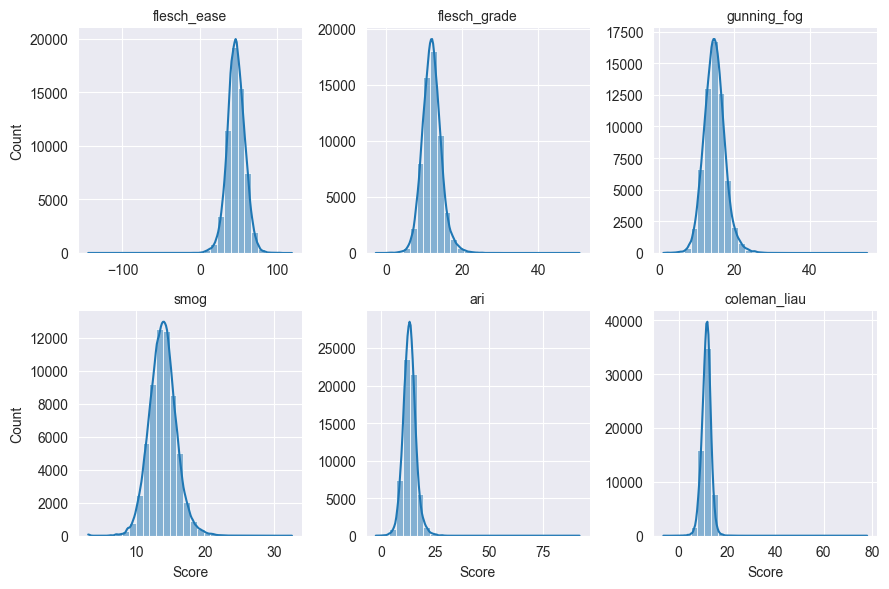

In [34]:
plt.figure(figsize=(12, 8))
g = sns.FacetGrid(
    df_readability,
    col="metric",
    col_wrap=3,
    sharex=False,
    sharey=False,
    height=3
)

g.map_dataframe(sns.histplot, x="score", bins=30, kde=True)
g.set_titles("{col_name}")
g.set_xlabels("Score")
g.set_ylabels("Count")
plt.tight_layout()
plt.show()

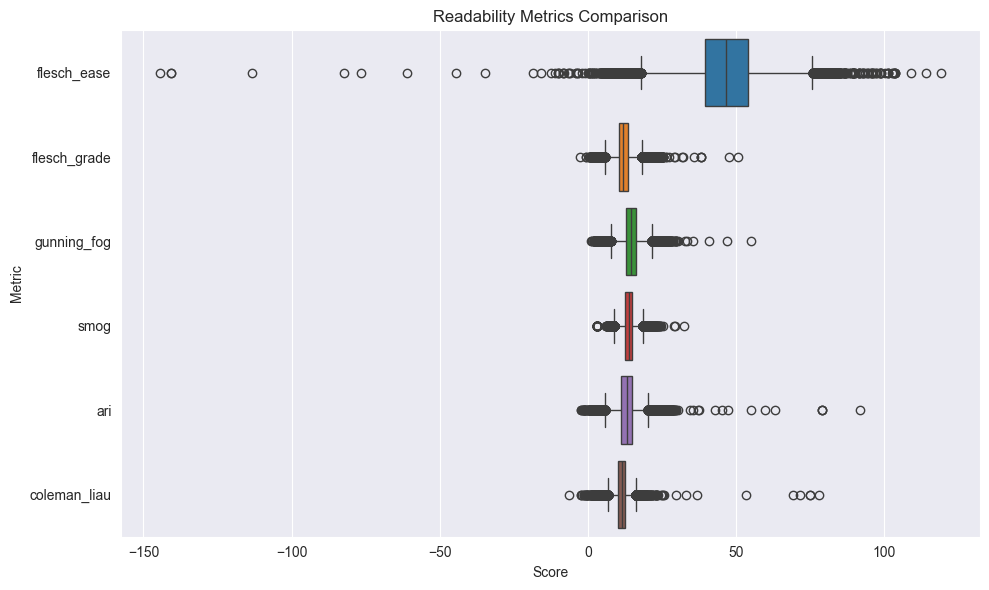

In [35]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[readability_cols], orient="h")
plt.title("Readability Metrics Comparison")
plt.xlabel("Score")
plt.ylabel("Metric")
plt.tight_layout()
plt.show()

In [36]:
cat_order = [
    "Very Easy - 5th grade",
    "Easy - 6th grade",
    "Fairly Easy - 7th grade",
    "Standard - 8th-9th grade",
    "Fairly Difficult - 10th-12th grade",
    "Difficult - College",
    "Very Difficult - College Graduate"
]


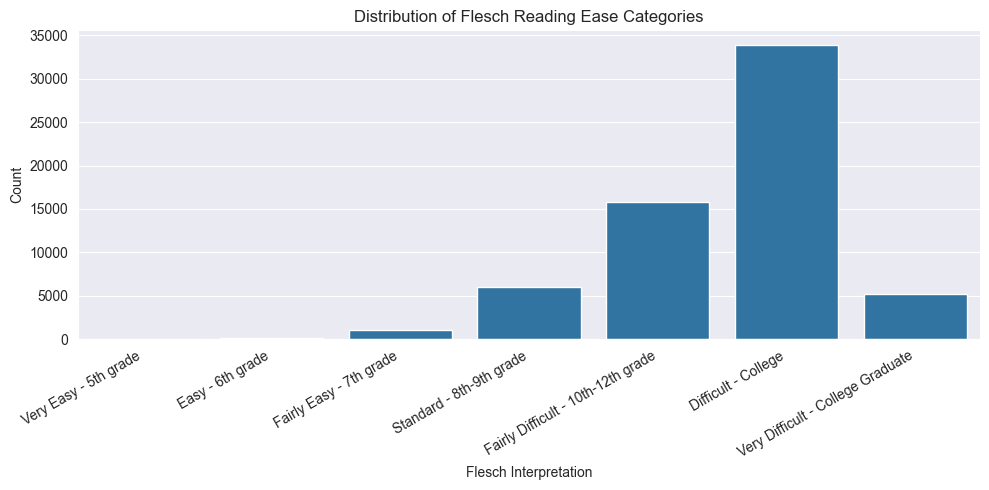

In [37]:
plt.figure(figsize=(10, 5))
sns.countplot(
    data=df,
    x="flesch_interpretation",
    order=[c for c in cat_order if c in df["flesch_interpretation"].unique()]
)
plt.title("Distribution of Flesch Reading Ease Categories")
plt.xlabel("Flesch Interpretation")
plt.ylabel("Count")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

Another part of the corpus that might give us some clue is the number of punctuaton and what's the ratio with words.

In [38]:
def count_punctuations(text):
    if not isinstance(text, str):
        return 0
    return sum(1 for ch in text if ch in string.punctuation)

In [39]:
def count_words(text):
    if not isinstance(text, str) or not text.strip():
        return 1
    return len(text.split())

Let's now count unique words and compute the ratio of unique words to total text length This way we can analyze the lexical diversity of the text, it might be a clue on identifying fake news from real news.

In [40]:
df["punct_count"] = df["text"].apply(count_punctuations)
df["word_count"]  = df["text"].apply(count_words)
df["punct_ratio"] = df["punct_count"] / df["word_count"]

Let's visualize the distribution of the punctuation count

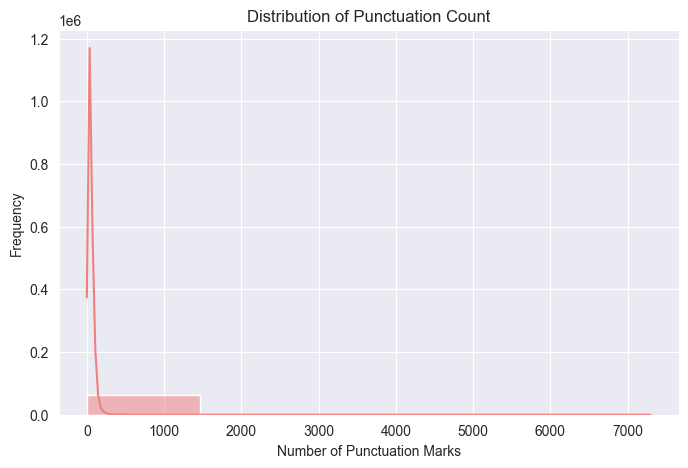

In [41]:
plt.figure(figsize=(8,5))
sns.histplot(df["punct_count"], bins=5, kde=True, color="lightcoral")
plt.title("Distribution of Punctuation Count")
plt.xlabel("Number of Punctuation Marks")
plt.ylabel("Frequency")
plt.show()

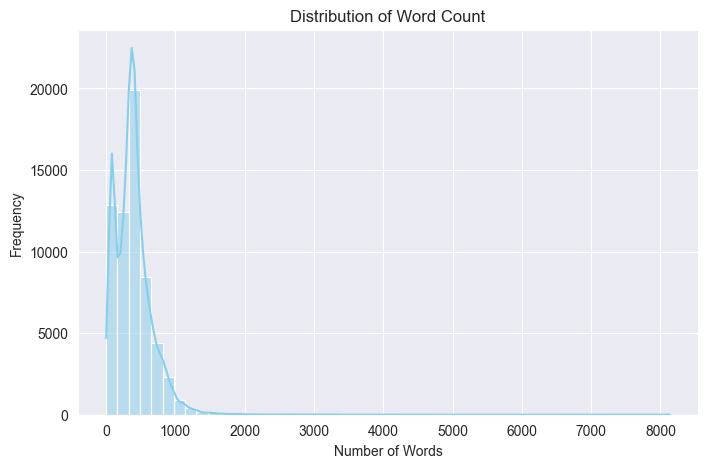

In [42]:
plt.figure(figsize=(8,5))
sns.histplot(df["word_count"], bins=50, kde=True, color="skyblue")
plt.title("Distribution of Word Count")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

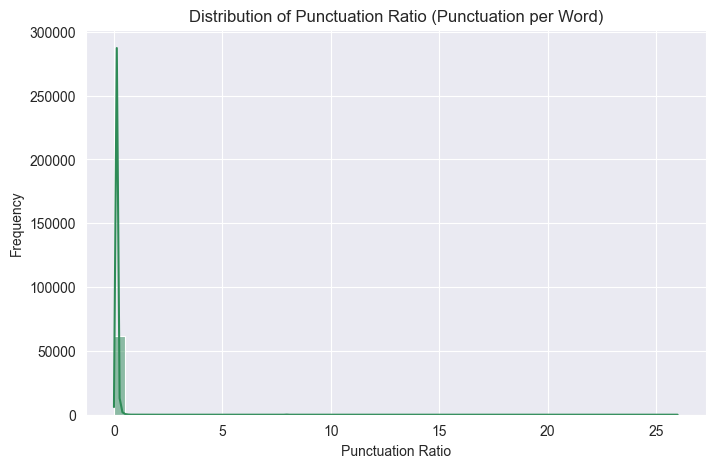

In [43]:
plt.figure(figsize=(8,5))
sns.histplot(df["punct_ratio"], bins=50, kde=True, color="seagreen")
plt.title("Distribution of Punctuation Ratio (Punctuation per Word)")
plt.xlabel("Punctuation Ratio")
plt.ylabel("Frequency")
plt.show()

In [44]:
nlp = spacy.load("en_core_web_sm", disable=["tagger", "parser"])  # keep NER

Let's use SpaCy to count the number of named entities in each text. NER give us the important entities in the text such as dates, monetary values, products, etc.

In [45]:
texts = df["prep_text"].fillna("").tolist()
entity_counts = []

for doc in nlp.pipe(texts, batch_size=100):
    entity_counts.append(len(doc.ents))


C:\Users\Owner\PycharmProjects\TrustNet\.venv\Lib\site-packages\spacy\pipeline\lemmatizer.py:188: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [46]:
df["entity_count"] = entity_counts

Convert cleaned text into numerical TF-IDF features (1- and 2-grams)

In [47]:
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_tfidf = tfidf.fit_transform(df["prep_text"])

Merge TF-IDF matrix with numeric features like polarity, subjectivity, etc.

In [48]:
numeric_feats = df[["polarity", "subjectivity", "text_len", "avg_word_len"]].fillna(0).values
X_full = hstack([X_tfidf, numeric_feats])

Identify which numeric features are most related to the label `real`

In [49]:
corrs = df.corr(numeric_only=True)["real"].sort_values(ascending=False)
print(corrs)

real              1.000000
smog              0.401916
gunning_fog       0.401738
flesch_grade      0.397306
coleman_liau      0.383229
grade_level       0.364913
ari               0.364895
entity_count      0.163239
avg_word_len      0.162847
sentence_count   -0.019534
polarity         -0.025019
punct_ratio      -0.047456
text_len         -0.054482
word_count       -0.056424
punct_count      -0.085365
subjectivity     -0.317270
flesch_ease      -0.442964
num_sents              NaN
Name: real, dtype: float64


Looking at the extreme of the our list, lexical_richness has a very small correlation with our label, whereas subjectivity has a somewhat strong negative correlation with our label

In [50]:
df.to_csv("../data/preprocessed/fakenews_preprocessed.csv", index=False)